Imports

In [6]:
import pandas as pd
import numpy as np
from numpy.random import beta
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

### Fetch Data and Compute Correlation Matrices of stocks

In [53]:
import random
import yfinance as yf

# Fetch historical price data
#tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]

sp500 = pd.read_csv('sp500.csv',delimiter=';').iloc[: , 1:]
alltickers = list(sp500['Symbol'])

Randomly select n of the stocks to create an correlation matrix

In [72]:
n=80

In [73]:
sometickers = random.sample(alltickers, min(n, len(alltickers)))
prices = yf.download(sometickers, start="2020-01-01", end="2021-01-01")["Adj Close"]

# Compute the correlation matrix
corr_matrix = prices.pct_change().dropna().corr()
corr_matrix

[*********************100%***********************]  80 of 80 completed


,ABT,ADSK,AFL,ALLE,APD,ATO,BA,BAC,BAX,BBY,...,TAP,TFX,TRGP,TSCO,TYL,UBER,VFC,VLO,WST,ZION
ABT,1.000000,0.525226,0.436052,0.577321,0.642144,0.621420,0.365005,0.528980,0.717057,0.527293,...,0.440640,0.607744,0.166106,0.404861,0.521396,0.205493,0.490342,0.313554,0.639366,0.315524
ADSK,0.525226,1.000000,0.504017,0.605081,0.622329,0.449240,0.498109,0.576077,0.494484,0.594657,...,0.467176,0.599023,0.445218,0.443513,0.638906,0.487077,0.528344,0.492114,0.490125,0.374148
AFL,0.436052,0.504017,1.000000,0.699435,0.561544,0.531959,0.750340,0.743319,0.391604,0.590875,...,0.632001,0.710614,0.588938,0.247450,0.319891,0.509565,0.749304,0.738670,0.272292,0.683714
ALLE,0.577321,0.605081,0.699435,1.000000,0.666042,0.700744,0.676600,0.741134,0.551380,0.610138,...,0.621664,0.666723,0.408044,0.368833,0.451585,0.366047,0.762121,0.658656,0.453331,0.654918
APD,0.642144,0.622329,0.561544,0.666042,1.000000,0.674239,0.453884,0.698508,0.661674,0.595849,...,0.586803,0.549422,0.347173,0.449572,0.516501,0.291355,0.612191,0.511219,0.502749,0.518577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBER,0.205493,0.487077,0.509565,0.366047,0.291355,0.159009,0.473689,0.421951,0.092618,0.440442,...,0.272663,0.468916,0.614479,0.312333,0.313405,1.000000,0.358281,0.466474,0.188602,0.313072
VFC,0.490342,0.528344,0.749304,0.762121,0.612191,0.615420,0.657608,0.810638,0.481467,0.618283,...,0.683248,0.605820,0.470658,0.233756,0.300819,0.358281,1.000000,0.704318,0.317498,0.753184
VLO,0.313554,0.492114,0.738670,0.658656,0.511219,0.471017,0.654609,0.728206,0.366700,0.472935,...,0.618324,0.641758,0.585513,0.225556,0.275981,0.466474,0.704318,1.000000,0.189801,0.745766
WST,0.639366,0.490125,0.272292,0.453331,0.502749,0.482794,0.203918,0.359984,0.599957,0.423701,...,0.220791,0.433209,0.170508,0.534352,0.558155,0.188602,0.317498,0.189801,1.000000,0.183864


Apply Hierarchical Risk Parity model

In [9]:
hrp_weights = HRPOpt(prices).optimize()
hrp_weights

OrderedDict([('AAPL', 0.050358615857420214),
             ('AMZN', 0.07957442801779202),
             ('GOOGL', 0.7724896860703766),
             ('META', 0.015757906718622858),
             ('MSFT', 0.0818193633357883)])

### Define the function to sample uniform correlated matrices

In [11]:
seed(42)
def sample_unif_correlmat(dimension):
    d = dimension + 1

    prev_corr = np.matrix(np.ones(1))
    for k in range(2, d):
        # sample y = r^2 from a beta distribution
        # with alpha_1 = (k-1)/2 and alpha_2 = (d-k)/2
        y = beta((k - 1) / 2, (d - k) / 2)
        r = np.sqrt(y)

        # sample a unit vector theta uniformly from
        # the unit ball surface B^(k-1)
        v = randn(k-1)
        theta = v / np.linalg.norm(v)

        # set w = r theta
        w = np.dot(r, theta)

        # set q = prev_corr**(1/2) w
        q = np.dot(sqrtm(prev_corr), w)

        next_corr = np.zeros((k, k))
        next_corr[:(k-1), :(k-1)] = prev_corr
        next_corr[k-1, k-1] = 1
        next_corr[k-1, :(k-1)] = q
        next_corr[:(k-1), k-1] = q

        prev_corr = next_corr
        
    return next_corr

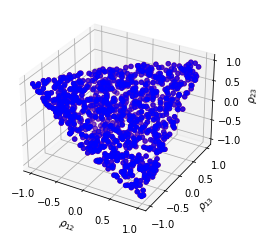

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 1000

correlmats = [sample_unif_correlmat(3) for i in range(n)]
xs = [correlmat[0,1] for correlmat in correlmats]
ys = [correlmat[0,2] for correlmat in correlmats]
zs = [correlmat[1,2] for correlmat in correlmats]


for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', 'o', -30, -5)]:
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('$\\rho_{12}$')
ax.set_ylabel('$\\rho_{13}$')
ax.set_zlabel('$\\rho_{23}$')

plt.show()

### Sampling variances from a multimodal distribution

In [13]:
def sample_daily_volatilities(dim):
    # 1. sample from a multinomial
    components = np.random.multinomial(
        dim, [0.1, 0.2, 0.4, 0.2, 0.1])

    # 2. sample from the corresponding Gaussian
    mean_daily_vols = [
        0.1 / np.sqrt(252),
        0.2 / np.sqrt(252),
        0.3 / np.sqrt(252),
        0.4 / np.sqrt(252),
        0.5 / np.sqrt(252),
    ]

    stds = [
        0.0005,
        0.0015,
        0.0015,
        0.0015,
        0.0010,
    ]

    daily_volatilities = []
    for i, compos in enumerate(components):
        daily_volatilities.extend(list(np.random.normal(
            loc=mean_daily_vols[i], scale=stds[i], size=compos)))

    return np.array(daily_volatilities)

In [14]:
nb_samples = 1000000

daily_volatilities = sample_daily_volatilities(nb_samples)

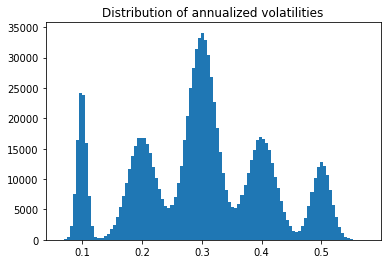

In [15]:
plt.hist(np.sqrt(252) * daily_volatilities, bins=100)
plt.title('Distribution of annualized volatilities')
plt.show()

### Generating a Random Covariance Matrix

In [49]:
def sample_cov_matrix(dim):
    correl_mat = sample_unif_correlmat(dim)
    daily_volatilities = sample_daily_volatilities(dim)
    
    return pd.DataFrame(
        np.multiply(correl_mat,
                    np.outer(daily_volatilities,
                             daily_volatilities)))

### Definitions of the Weighting Methods

In [17]:
def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))


def compute_RP_weights(covariances):
    weights = (1 / np.diag(covariances)) 
    
    return weights / sum(weights)


def compute_unif_weights(covariances):
    
    return [1 / len(covariances) for i in range(len(covariances))]


def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage


def compute_HRP_weights(covariances):
    vols = np.sqrt(np.diag(covariances))
    correl_mat = np.multiply(covariances,
                         np.outer(vols**-1, vols**-1))
    # deal with precision errors
    np.fill_diagonal(correl_mat.values, 1)
    distances = np.sqrt((1 - correl_mat) / 2)
    # deal with precision errors
    np.fill_diagonal(distances.values, 0)
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(
        distances.values, method='single')
    weights = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        for subcluster in range(0, len(clustered_alphas), 2):
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]

            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights

In [25]:
cov = sample_cov_matrix(5)

(list(compute_MV_weights(cov)),
 list(compute_RP_weights(cov)),
 list(compute_unif_weights(cov)),
 list(compute_HRP_weights(cov)),
)

([0.5966774817299298,
  -0.2752974238706028,
  0.042803393727436245,
  0.4662975872673585,
  0.16951896114587825],
 [0.5059367585872238,
  0.13876751657057687,
  0.12488915265648427,
  0.12179673243672887,
  0.10860983974898612],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.06800293730198977,
  0.06120185348620903,
  0.18017913674280964,
  0.5685623483706024,
  0.1220537240983892])

### Statistics in- and out-sample: portfolio volatility

- In-sample testing uses **historical** data to generate a forecast
- Out-of-sample testing uses **recent** data, not used in the model's development

In [27]:
def compute_portfolio_volatility(weights, returns):
    return ((weights * returns)
            .sum(axis=1)
            .std() * np.sqrt(252))

In [26]:
def generate_returns_sample(covariances, horizon=252):
    return pd.DataFrame(
        np.random.multivariate_normal(
        np.zeros(len(covariances)), covariances,
        size=horizon))

**Comparing in/out sample for each method**

In [74]:
true_covariances = corr_matrix

In [75]:
in_sample = generate_returns_sample(true_covariances, horizon=3 * 252)
out_sample = generate_returns_sample(true_covariances, horizon=3 * 21)

methods = {
    'Minimum Variance': compute_MV_weights,
    'Risk Parity': compute_RP_weights,
    'Equal Weighting': compute_unif_weights,
    'Hierarchical Risk Parity': compute_HRP_weights,
}

In [76]:
for name, method in methods.items():
    in_sample_weights = method(in_sample.cov())
    
    in_sample_vol = compute_portfolio_volatility(
        in_sample_weights, in_sample)
    
    out_sample_vol = compute_portfolio_volatility(
        in_sample_weights, out_sample)
    
    print(name + ':\n' +
          'in-sample vol: ' + str(round(in_sample_vol, 4)) + '\n' +
          'out-sample vol: ' + str(round(out_sample_vol, 4)) +
          '\n\n')

Minimum Variance:
in-sample vol: 4.7744
out-sample vol: 4.9665


Risk Parity:
in-sample vol: 11.386
out-sample vol: 10.3781


Equal Weighting:
in-sample vol: 11.4281
out-sample vol: 10.4035


Hierarchical Risk Parity:
in-sample vol: 10.7381
out-sample vol: 9.8448




### Monte Carlo study: Distribution of volatilities in-sample vs. out-sample

In [15]:
empirical_volatilities = {method: {'in-sample' : [], 'out-sample': []}
                          for method in methods.keys()}

nb_experiments = 2000
for experiment in tqdm(range(nb_experiments)):
    true_covariances = sample_cov_matrix(500)
    in_sample = generate_returns_sample(
        true_covariances, horizon=3 * 252)
    out_sample = generate_returns_sample(
        true_covariances, horizon=3 * 252)
    
    for name, method in methods.items():
        in_sample_weights = method(in_sample.cov())

        in_sample_vol = compute_portfolio_volatility(
            in_sample_weights, in_sample)

        out_sample_vol = compute_portfolio_volatility(
            in_sample_weights, out_sample)

        empirical_volatilities[name][
            'in-sample'].append(in_sample_vol)
        empirical_volatilities[name][
            'out-sample'].append(out_sample_vol)

  1%|▏         | 27/2000 [32:40<39:48:14, 72.63s/it]


KeyboardInterrupt: 

In [ ]:
for method, distribs in empirical_volatilities.items():
    plt.hist(distribs['in-sample'], bins=100, label='in-sample', alpha=0.7)
    plt.hist(distribs['out-sample'], bins=100, label='out-sample', alpha=0.7)
    plt.title(method)
    plt.legend(loc=1)
    plt.show()